In [1]:
import demo_util
import numpy as np
import torch

from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert
from modeling.titok import TiTok

attention mode is flash


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


attention mode is flash


In [6]:
# load the pretrained models from huggingface
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
#titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [7]:
config = demo_util.get_config("configs/titok_s128.yaml")

In [8]:
print(config)

{'experiment': {'tokenizer_checkpoint': 'tokenizer_titok_s128.bin', 'generator_checkpoint': 'generator_titok_s128.bin', 'output_dir': 'titok_s_128'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'small', 'vit_dec_model_size': 'small', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 128, 'finetune_decoder': True}, 'generator': {'model_type': 'UViT', 'hidden_size': 1024, 'num_hidden_layers': 20, 'num_attention_heads': 16, 'intermediate_size': 4096, 'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 64, 'mask_schedule_strategy': 'arccos', 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000, 'randomize_temperature': 2.8, 'guidance_scale': 6.9, 'guidance_decay': 'power-cosine'}}, 'dataset': {'preprocessing': {'crop_size': 256}}}


In [5]:
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_s128_imagenet")
titok_tokenizer.eval()
titok_tokenizer.requires_grad_(False)
# or alternatively, downloads from hf

# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# titok_tokenizer = demo_util.get_titok_tokenizer(config)

print(titok_tokenizer)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--yucornetto--tokenizer_titok_s128_imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages

OSError: [Errno 28] No space left on device

In [12]:
# supported generator: [generator_titok_l32_imagenet, generator_titok_b64_imagenet, generator_titok_s128_imagenet]
titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_s128_imagenet")
titok_generator.eval()
titok_generator.requires_grad_(False)

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")
# titok_generator = demo_util.get_titok_generator(config)
print(titok_generator)

ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 1024)
      (position_embeddings): Embedding(129, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-19): 20 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affin

In [7]:
device = "cuda"
titok_tokenizer = titok_tokenizer.to(device)
#titok_generator = titok_generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [8]:
# Tokenize an Image into 32 discrete tokens

def tokenize_and_reconstruct(img_path):
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(original_image)
    print("reconstructed image:")
    display(reconstructed_image)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Input Image is represented by codes tensor([[[1255, 2603,  982, 2222,  643, 1426,  866, 4094,  296, 1422,  398,
           764, 3670, 1265, 3986,  759, 1039, 3962, 2373, 2337, 1372, 4050,
          4012, 3644, 2624, 3735, 1539, 1289, 2817, 2985, 2550, 2972]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


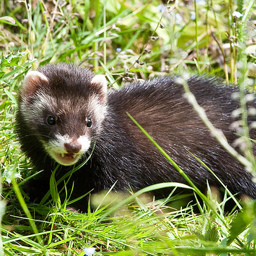

reconstructed image:


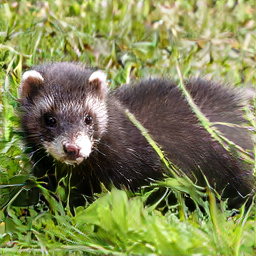

In [9]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")

Input Image is represented by codes tensor([[[3983,  514, 2048, 1195, 1165, 1656,  243,  537,   67, 3538, 2894,
          1035, 3521,  996, 3258, 3913,  255, 2966,  625, 3056, 2405, 3133,
          1726, 3958, 3605, 2352, 1964, 1738, 3133, 1781,  400, 2267]]],
       device='mps:0') with shape torch.Size([1, 1, 32])
orginal image:


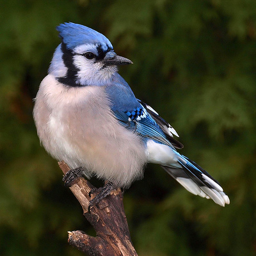

reconstructed image:


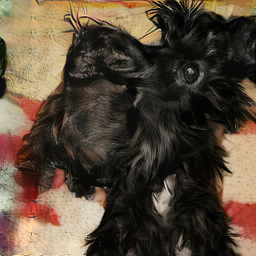

In [7]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")

## Generate an image from 32 discrete tokens

In [ ]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))

NameError: name 'titok_generator' is not defined